<a href="https://colab.research.google.com/github/OrionXV/AI7101-Project/blob/main/CleanStart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(Github stuff)

In [1]:
!rm -rf AI7101-Project
!git clone https://github.com/OrionXV/AI7101-Project.git

Cloning into 'AI7101-Project'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 66 (delta 29), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 5.75 MiB | 4.71 MiB/s, done.
Resolving deltas: 100% (29/29), done.


## Import the data
Load the data using pandas and split the data frame into X (inputs) and y (outputs). (2 points)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer

# Suppress warnings for clarity
import warnings
warnings.filterwarnings('ignore')

In [7]:
BASE_DIR = '/content/AI7101-Project/data'

TRAIN_PATH        = os.path.join(BASE_DIR, 'train.csv')            # pump features only
TRAIN_TARGETS_PATH= os.path.join(BASE_DIR, 'training_labels.csv')  # id + status_group
TEST_PATH         = os.path.join(BASE_DIR, 'test.csv')             # for final submission
SUBMISSION_PATH   = os.path.join(BASE_DIR, 'submission.csv')       # sample submission

In [8]:
train_features = pd.read_csv(TRAIN_PATH)
train_targets  = pd.read_csv(TRAIN_TARGETS_PATH)
test_df        = pd.read_csv(TEST_PATH)

In [9]:
df = train_features.merge(train_targets, on='id', how='inner', validate='one_to_one')
print("Merged training shape:", df.shape)
print("Class distribution:")
print(df['status_group'].value_counts(normalize=True))
y = df['status_group']                 # labels
X = df.drop(columns=['status_group'])  # features


Merged training shape: (59400, 41)
Class distribution:
status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64


## Prepare your dataset:
- encode categorical variables
- handle missing variables
- generate new features (if you have some intuition that these features can be helpful).
- Preprocess the target variable if needed (e.g., combine various classification problems into a single one or convert the target variable to a binary one).
- For each transformation, give a clear explanation of your motivation. (5 points)


In [10]:
print("\nNumber of unique values per column:")
print(X.nunique().sort_values())

print("\nMissing values per column:")
missing = X.isna().sum()
print(missing[missing > 0])

print("\nCounts of zeros in selected numeric fields:")
for col in ['construction_year','gps_height','longitude','latitude','population']:
    if col in X.columns:
        print(f"{col}: {(X[col]==0).sum()} zeros")


Number of unique values per column:
recorded_by                  1
public_meeting               2
permit                       2
source_class                 3
quantity                     5
quantity_group               5
management_group             5
quality_group                6
waterpoint_type_group        6
payment                      7
source_type                  7
waterpoint_type              7
payment_type                 7
extraction_type_class        7
water_quality                8
basin                        9
source                      10
scheme_management           11
management                  12
extraction_type_group       13
extraction_type             18
district_code               20
region                      21
region_code                 27
construction_year           55
num_private                 65
amount_tsh                  98
lga                        125
date_recorded              356
population                1049
funder                    1896
wa

In [11]:
def preprocess_data(df):
    df_proc = df.copy()

    # 1 Drop high-cardinality or low-information columns
    drop_cols = ['wpt_name', 'subvillage', 'recorded_by']
    df_proc.drop(columns=[c for c in drop_cols if c in df_proc.columns], inplace=True)

    # 2 Handle construction year:
    #     - Replace 0 with sampled year from empirical distribution
    #     - Create pump age and construction decade
    if 'construction_year' in df_proc.columns:
        years = df_proc['construction_year']
        non_zero_years = years[years > 0]
        if not non_zero_years.empty:
            year_probs = non_zero_years.value_counts(normalize=True)
            df_proc['construction_year'] = df_proc['construction_year'].apply(
                lambda x: np.random.choice(year_probs.index, p=year_probs.values) if x == 0 else x)
            # Create derived features
            record_years = pd.to_datetime(df_proc['date_recorded']).dt.year
            df_proc['pump_age']          = record_years - df_proc['construction_year']
            df_proc['construction_decade'] = (df_proc['construction_year'] // 10) * 10

    # 3 Extract date components
    if 'date_recorded' in df_proc.columns:
        dt = pd.to_datetime(df_proc['date_recorded'])
        df_proc['record_year']  = dt.dt.year
        df_proc['record_month'] = dt.dt.month
        df_proc['record_day']   = dt.dt.day
        df_proc.drop(columns=['date_recorded'], inplace=True)

    # 4 Replace zeros in geographic coordinates with NaN
    for col in ['longitude', 'latitude', 'gps_height']:
        if col in df_proc.columns:
            df_proc[col] = df_proc[col].replace(0, np.nan)

    # 5 Impute missing numeric values by mean within geographic group (basin, region, lga, ward)
    group_cols = ['basin', 'region', 'lga', 'ward']
    for col in ['population', 'gps_height', 'longitude', 'latitude']:
        if col in df_proc.columns:
            df_proc[col] = df_proc.groupby(group_cols)[col].transform(lambda x: x.fillna(x.mean()))

    # 6 Simplify payment and related columns
    if 'payment' in df_proc.columns:
        df_proc['has_payment'] = df_proc['payment'].apply(lambda x: 0 if x == 'never pay' else 1)
    if 'permit' in df_proc.columns:
        df_proc['permit'] = df_proc['permit'].map({True: 1, False: 0})
    if 'public_meeting' in df_proc.columns:
        df_proc['public_meeting'] = df_proc['public_meeting'].map({True: 1, False: 0})

    # 7 Drop redundant categorical pairs (keep only one of each)
    redundant_pairs = [
        ('extraction_type_group', 'extraction_type_class'),
        ('water_quality', 'quality_group'),
        ('quantity', 'quantity_group'),
        ('source', 'source_class'),
        ('source_type', 'source_class'),
        ('waterpoint_type', 'waterpoint_type_group'),
        ('payment_type', 'payment'),
        ('management_group', 'management'),
        ('region', 'region_code'),
    ]
    for a, b in redundant_pairs:
        if a in df_proc.columns and b in df_proc.columns:
            df_proc.drop(columns=[b], inplace=True)

    # 8 Identify categorical and numeric columns
    categorical_cols = df_proc.select_dtypes(include=['object']).columns
    numeric_cols     = df_proc.select_dtypes(include=['int64', 'float64']).columns

    return df_proc, categorical_cols, numeric_cols

# Apply preprocessing to X
X_proc, cat_cols, num_cols = preprocess_data(X)
print("\nProcessed feature shape:", X_proc.shape)
display(X_proc.head())


Processed feature shape: (59400, 34)


,id,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,region,...,quantity,source,source_type,waterpoint_type,pump_age,construction_decade,record_year,record_month,record_day,has_payment
0,69572,6000.0,Roman,1390.0,Roman,34.938093,-9.856322,0,Lake Nyasa,Iringa,...,enough,spring,spring,communal standpipe,12,1990,2011,3,14,1
1,8776,0.0,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,0,Lake Victoria,Mara,...,insufficient,rainwater harvesting,rainwater harvesting,communal standpipe,3,2010,2013,3,6,0
2,34310,25.0,Lottery Club,686.0,World vision,37.460664,-3.821329,0,Pangani,Manyara,...,enough,dam,dam,communal standpipe multiple,4,2000,2013,2,25,1
3,67743,0.0,Unicef,263.0,UNICEF,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mtwara,...,dry,machine dbh,borehole,communal standpipe multiple,27,1980,2013,1,28,0
4,19728,0.0,Action In A,NaN,Artisan,31.130847,-1.825359,0,Lake Victoria,Kagera,...,seasonal,rainwater harvesting,rainwater harvesting,communal standpipe,3,2000,2011,7,13,0


## Exploratory Analysis W/ Seaborn

- find meaningful patterns in the data that can be used to make a machine learning task more specific or to help with selection and tuning ML models.
- Perform additional data preprocessing if your findings suggest this (explain why).
- If there are several options for target variables, you can select some of them after this step with a couple of sentences explaining your choice. (4 points).

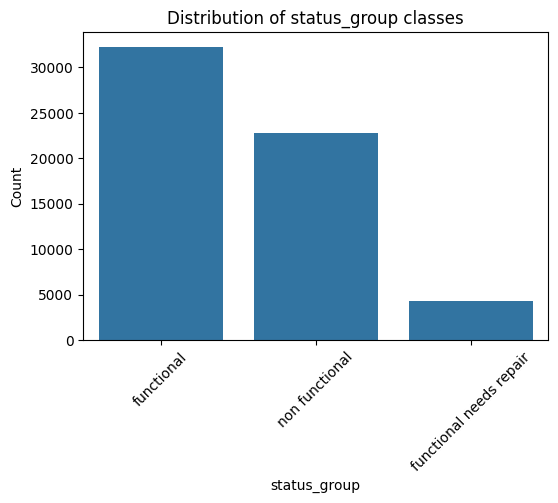

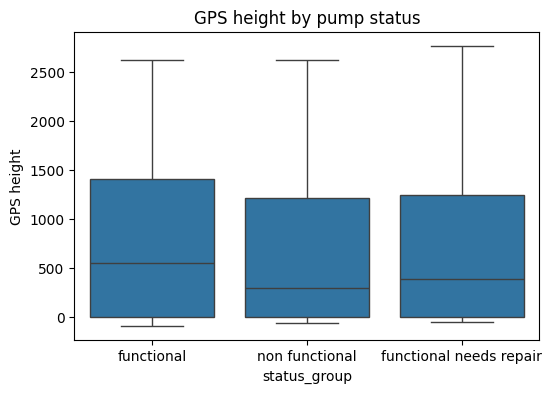

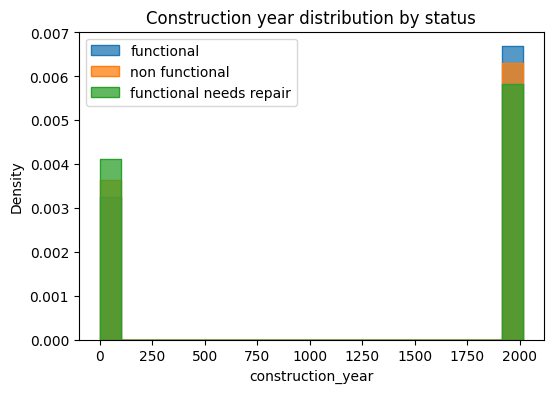

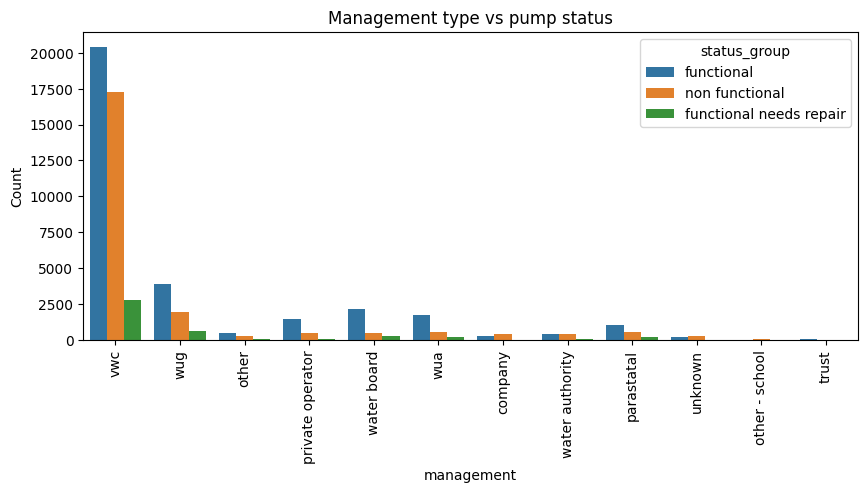

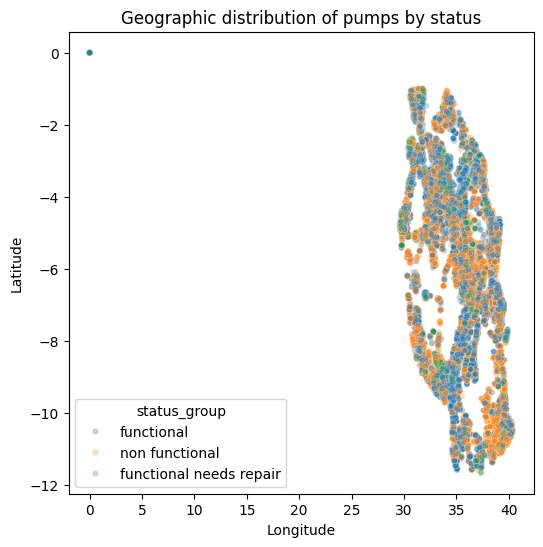

In [12]:
# 1 – Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Distribution of status_group classes')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.xlabel('status_group')
plt.show()

# 2 – Numeric feature distributions by class
# Example: gps_height
plt.figure(figsize=(6,4))
sns.boxplot(x=y, y=df['gps_height'])
plt.title('GPS height by pump status')
plt.ylabel('GPS height')
plt.xlabel('status_group')
plt.show()

# Histogram of construction_year for each class
plt.figure(figsize=(6,4))
for status in y.unique():
    sns.histplot(df[df['status_group'] == status]['construction_year'],
                 label=status, element='step', stat='density', bins=20)
plt.legend()
plt.title('Construction year distribution by status')
plt.xlabel('construction_year')
plt.ylabel('Density')
plt.show()

# 3 – Categorical feature vs target
# Example: management
plt.figure(figsize=(10,4))
sns.countplot(x=df['management'], hue=y)
plt.title('Management type vs pump status')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.xlabel('management')
plt.show()

# 4 – Spatial patterns
plt.figure(figsize=(6,6))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=y, alpha=0.3, s=20)
plt.title('Geographic distribution of pumps by status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# TODO: add any further preprocessing steps suggested by EDA here
# For example, if `amount_tsh` is skewed, log-transform it:
# if 'amount_tsh' in X_proc.columns:
#     X_proc['amount_tsh_log'] = np.log1p(X_proc['amount_tsh'])
#     X_proc.drop(columns=['amount_tsh'], inplace=True)

# You can also merge rare categories:
# for col in cat_cols:
#     top_cats = X_proc[col].value_counts().nlargest(10).index
#     X_proc[col] = X_proc[col].where(X_proc[col].isin(top_cats), other='Other')


## Cross-validation
- select an appropriate measure of quality (the selection of both things should be motivated by your data).
- Choose an ML model reasonably; look for a good set of hyperparameters.
- Use the prepared cross-validation procedure to estimate the quality of prediction (7 points).